In [10]:
import matplotlib.pyplot as pl
import numpy as np
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
%matplotlib inline

## Analysis of the cube

Let's start by lazyly opening the file with `astropy.io.fits`

In [62]:
f = fits.open('sky_ldev.fits')

The header contains relevant information about the file: how to reconstruct the axis, number of elements of the cube, etc.

In [70]:
print(f[0].header)

SIMPLE  =                    T  /                                               BITPIX  =                  -32  /                                               NAXIS   =                    3  /                                               NAXIS1  =                 1286  /                                               NAXIS2  =                 1286  /                                               NAXIS3  =                 6668  /                                               EXTEND  =                    T  /                                               BSCALE  =    1.00000000000E+00  /                                               BZERO   =    0.00000000000E+00  /                                               BLANK   =                   -1  /                                               BUNIT   = 'Jy/beam '  /                                                         CRPIX1  =    6.43000000000E+02  /                                               CDELT1  =   -7.77777777778E-04  /       

The cube is of size

In [59]:
f[0].data.shape

(6668, 1286, 1286)

where the first element refers to the frequency axis and the remaining two refer to the spatial coordinates given in right ascension and declination.

## Coordinates
Instead of reconstructing the coordinates by hand, let us use the World Coordinate System methods of `astropy`. Let us generate the wcs object that will be used to reconstruct all coordinates.

In [72]:
wcs=WCS(f[0].header)
wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---SIN'  'DEC--SIN'  'FREQ'  
CRVAL : 180.0  -30.0  950000000.0  
CRPIX : 643.0  643.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.000777777777778  0.000777777777778  30000.0  
NAXIS : 1286  1286  6668

As an example, we can compute the coordinates of the pixel (20,20,20), which is given in `SkyCoord` coordinates.

In [73]:
coord = wcs.pixel_to_world(20, 20, 20)
coord

[<SkyCoord (ICRS): (ra, dec) in deg
     (180.56137725, -30.48259848)>,
 <Quantity 9.506e+08 Hz>]

Let's try to go back from physical units to pixel units by defining the coordinates by hand. We make use of the `units` package of `astropy`:

In [13]:
ra = 180.56137725 * u.deg
dec = -30.48259848 * u.deg
coords = SkyCoord(ra, dec, unit="deg")
freq = 9.506e+08 * u.Hz
wcs.world_to_pixel(coords, freq)

(array(19.99999691), array(19.99999401), array(20.))

We can then easily generate the coordinates for each axis, which might be interesting for later:

In [44]:
nx, ny, nf = wcs.pixel_shape
x = np.zeros(nx)
for i in range(nx):
    tmp = wcs.pixel_to_world(i, 0, 0)
    x[i] = tmp[0].ra.value
    
y = np.zeros(ny)
for i in range(ny):
    tmp = wcs.pixel_to_world(0, i, 0)
    y[i] = tmp[0].dec.value
    
freq = np.zeros(nf)
for i in range(nf):
    tmp = wcs.pixel_to_world(0, 0, i)
    freq[i] = tmp[1].value

## Catalog
Let's analyze the cube and see if we can detect by eye the source with the largest integrated flux in the line. The first thing is to read the catalog. One can use `pandas` for this but we use a simpler method reading it using `numpy.loadtxt`:

In [74]:
cat = np.loadtxt('sky_ldev_truthcat.txt', skiprows=1)[:, 1:]

We check that we've read it properly:

In [51]:
cat[0,:]

array([ 1.80191315e+02, -2.97410297e+01,  4.45197015e+00,  3.66910397e+00,
        1.12076659e+09,  9.18948822e+01,  5.33825989e+01,  1.46223896e+02])

Now we find the source with the largest integrated flux. The flux is given in the fourth column because we got rid of the index:

In [56]:
ind_peak = np.argmax(cat[:,3])
print(ind_peak)
print(cat[ind_peak, :])

841
[ 1.79799332e+02 -3.04431763e+01  1.87992370e+01  5.82329078e+02
  1.12422605e+09  1.76621185e+02  5.26458092e+01  3.61810514e+02]


It is located at line 841 in the catalog. Now we can use the values of ra, dec and frequency from the catalog to find the pixel coordinates in the cube:

In [65]:
ra = cat[ind_peak, 0] * u.deg
dec = cat[ind_peak, 1] * u.deg
coords = SkyCoord(ra, dec, unit="deg")
freq = cat[ind_peak, 4] * u.Hz
coords_peak = wcs.world_to_pixel(coords, freq)
print(coords_peak)

(array(864.43147461), array(72.01286392), array(5807.53493333))


It is located roughly at frequency 5807, so that we can show this slice from the cube and show some lines indicating the ra and dec positions. We check that the source is there so everything makes sense.

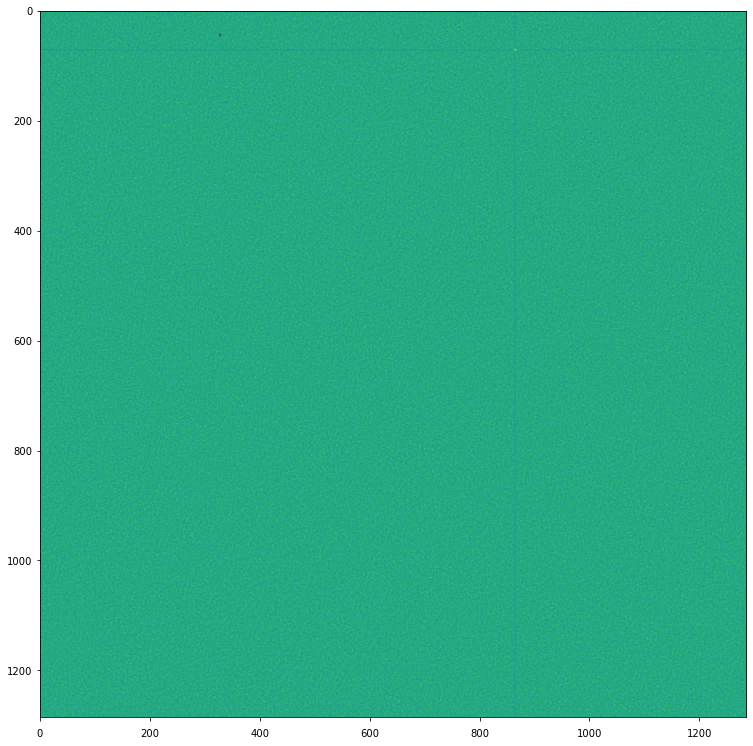

In [69]:
fig, ax = pl.subplots(figsize=(13,13))
ax.imshow(f[0].data[5807, :, :])
ax.axhline(coords_peak[1], alpha=0.2)
ax.axvline(coords_peak[0], alpha=0.2)